In [1]:
import pandas as pd
import numpy as np
import h3
import folium
from folium import Map, Marker, GeoJson
import json
from geojson.feature import *
import os
import sys
import shapely
import shapely.wkt
from shapely.geometry import Polygon
import geopandas as gpd
from folium import plugins
from folium.plugins import HeatMap
import vaex
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import locale

## Constants

In [2]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']


In [3]:
df_cleaned = vaex.open('./data/trips_prepared.hdf5')

df_cleaned.get_column_names()

['trip_id',
 'taxi_id',
 'trip_start_timestamp',
 'trip_end_timestamp',
 'trip_seconds',
 'trip_miles',
 'pickup_census_tract',
 'dropoff_census_tract',
 'pickup_community_area',
 'dropoff_community_area',
 'fare',
 'tips',
 'tolls',
 'extras',
 'trip_total',
 'payment_type',
 'company',
 'pickup_centroid_latitude',
 'pickup_centroid_longitude',
 'pickup_centroid_location',
 'dropoff_centroid_latitude',
 'dropoff_centroid_longitude',
 'dropoff_centroid_location',
 'trip_start_hour',
 'trip_end_hour']

## Number of trips per cab.

In [16]:
df_taxis = df_cleaned.groupby(by=['taxi_id'], agg=vaex.agg.count())

num_taxis = len(df_taxis)
df_taxis.rename('_count', 'count')
df_taxis = df_taxis.to_pandas_df()
df_taxis = df_taxis.sort_values('count', ascending=False)

cumulative_sum = df_taxis['count'].cumsum()

total_rides = len(df_cleaned)
rides_90_percent = total_rides * 0.9
rides_75_percent = total_rides * 0.75
rides_50_percent = total_rides * 0.5

print(f"Of {num_taxis} Taxis and {total_rides} of rides:")
taxi_ids_90_percent = df_taxis['count'][cumulative_sum <= rides_90_percent].count()
taxi_ids_75_percent = df_taxis['count'][cumulative_sum <= rides_75_percent].count()
taxi_ids_50_percent = df_taxis['count'][cumulative_sum <= rides_50_percent].count()

print(f"Num. of Taxis do 90% of the drives: {taxi_ids_90_percent}")
print(f"Num. of Taxis do 75% of the drives: {taxi_ids_75_percent}")
print(f"Num. of Taxis do 50% of the drives: {taxi_ids_50_percent}")

print("mean number of trips per taxi: ", df_taxis['count'].mean())

Of 6736 Taxis and 21079769 of rides:
Num. of Taxis do 90% of the drives: 4569
Num. of Taxis do 75% of the drives: 3371
Num. of Taxis do 50% of the drives: 1915
mean number of trips per taxi:  3129.419388361045


## Average total time and distance traveled by each cab
The most taxis travel bewteen 0-20 minutes. Around 1000 between 20-40 and only very very few over 50 minutes 

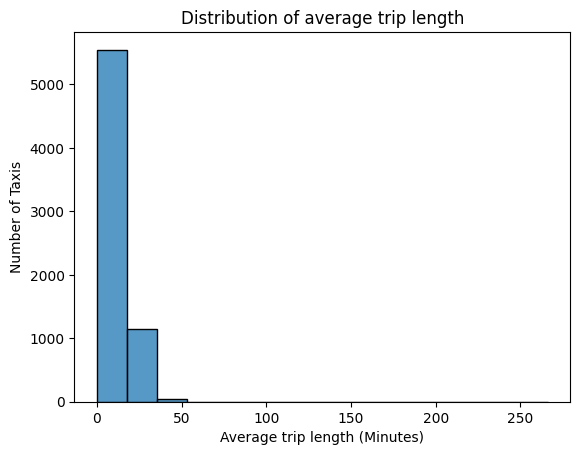

In [17]:
df_avg_trip_duration = df_cleaned.groupby('taxi_id', agg=vaex.agg.mean('trip_seconds'))

df_avg_trip_duration = df_avg_trip_duration.to_pandas_df()

df_avg_trip_duration['trip_seconds_mean'] = df_avg_trip_duration['trip_seconds_mean'] / 60

# Plot
sns.histplot(df_avg_trip_duration['trip_seconds_mean'], bins=15)
plt.title('Distribution of average trip length')
plt.xlabel('Average trip length (Minutes)')
plt.ylabel('Number of Taxis')
plt.show()

Most taxis travel between 0-10 miles only a few travel over 10 miles on average

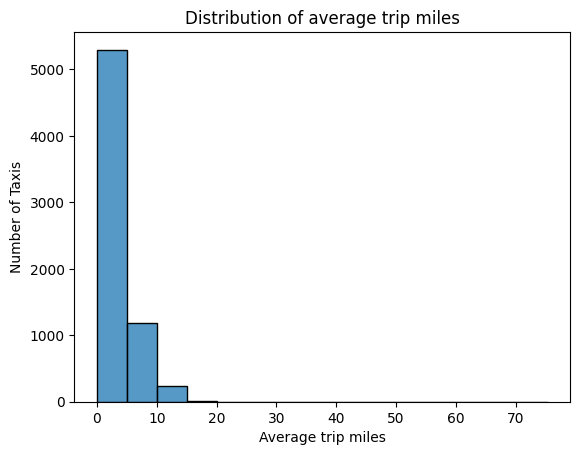

In [18]:
df_avg_trip_miles = df_cleaned.groupby('taxi_id', agg=vaex.agg.mean('trip_miles'))

df_avg_trip_miles = df_avg_trip_miles.to_pandas_df()

# Plot
sns.histplot(df_avg_trip_miles['trip_miles_mean'], bins=15)
plt.title('Distribution of average trip miles')
plt.xlabel('Average trip miles')
plt.ylabel('Number of Taxis')
plt.show()

## Trip Duration by Day of Week
The duration peaks in the middle of the weak and decreases till sunday and begins to rise after monday

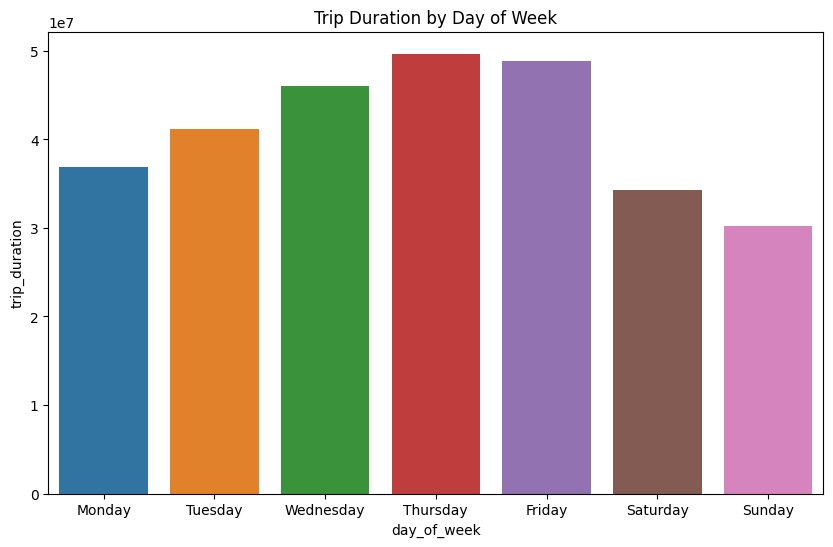

In [19]:
df = df_cleaned.to_pandas_df()

df['trip_start_timestamp'] = pd.to_datetime(df['trip_start_timestamp'])
df['trip_end_timestamp'] = pd.to_datetime(df['trip_end_timestamp'])

df['trip_duration'] = df['trip_seconds'] / 60

df['day_of_week'] = df['trip_start_timestamp'].dt.day_name()
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=days, ordered=True)

df_duration = df.groupby(['day_of_week'])['trip_duration'].sum().reset_index()
df_duration = df_duration.sort_values('day_of_week')


plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='trip_duration', data=df_duration)
plt.title('Trip Duration by Day of Week')
plt.show()

## Utilization
Determining the utilization was not an easy task, as we do not have exact data on how many drivers are used per taxi, how long a driver is on the road on average, when is a taxi without an order, or whether it is currently on its way to a customer. To get an approximate idea of how many cabs might be available or how many might be on the road at a given time, we iterated over each hour of the year and counted the number of cabs that were on the road during that hour. 

In [20]:

df = df_cleaned.copy()

# Fügen Sie eine Spalte für den Wochentag hinzu
df['start_hour_of_year'] = df['trip_start_timestamp'].dt.strftime("%m/%d/%Y - %H")
df_grouped = df.groupby('start_hour_of_year', agg={'count_taxis': vaex.agg.nunique('taxi_id')})
df_sorted = df_grouped.sort('start_hour_of_year')

all_hours = pd.date_range(start='1/1/2017', end='12/31/2017 23', freq='H')
all_hours_df = vaex.from_pandas(pd.DataFrame({'start_hour_of_year': all_hours, 'datetime':  all_hours}))

all_hours_df['start_hour_of_year'] = all_hours_df['start_hour_of_year'].dt.strftime("%m/%d/%Y - %H")

merged_df = all_hours_df.join(df_sorted, on='start_hour_of_year')
merged_df['count_taxis'] = merged_df['count_taxis'].fillna(0)


df_pd = merged_df.to_pandas_df()

unique_taxis_len = len(df_cleaned.taxi_id.unique())
df_pd['util'] = df_pd['count_taxis'] / unique_taxis_len  * 100
df_pd['available_taxis'] = unique_taxis_len - df_pd['count_taxis']


### Average Utilization for Weekdays

Average Utilization over weekdays: 20.654733361932845


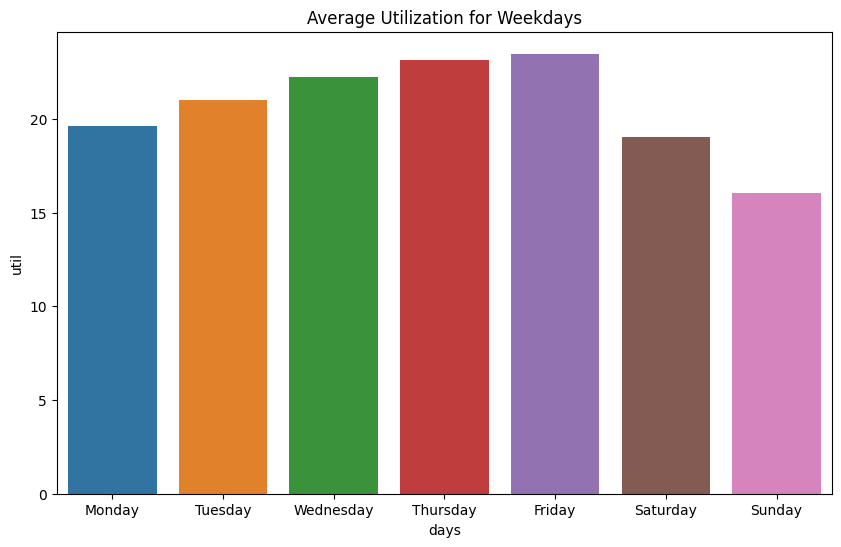

In [38]:
df_pd['days'] = df_pd['datetime'].dt.day_name()
df_pd['days'] = pd.Categorical(df_pd['days'], categories=days, ordered=True)

df_grouped = df_pd.groupby('days')['util'].mean().reset_index()

print("Average Utilization over weekdays: " + str(df_grouped['util'].mean()))

df_grouped = df_grouped.sort_values('days')


plt.figure(figsize=(10, 6))
sns.barplot(x='days', y='util', data=df_grouped)
plt.title('Average Utilization for Weekdays')
plt.show()


### Average Utilization for Hour of day

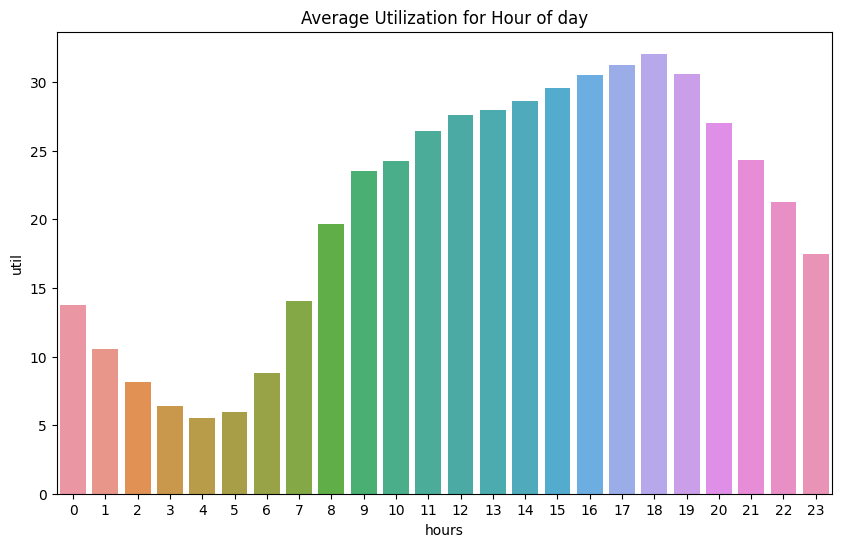

In [22]:
df_pd['hours'] = df_pd['datetime'].dt.hour

df_grouped = df_pd.groupby('hours')['util'].mean().reset_index()

df_grouped = df_grouped.sort_values('hours')


plt.figure(figsize=(10, 6))
sns.barplot(x='hours', y='util', data=df_grouped)
plt.title('Average Utilization for Hour of day')
plt.show()

### Average available taxis 

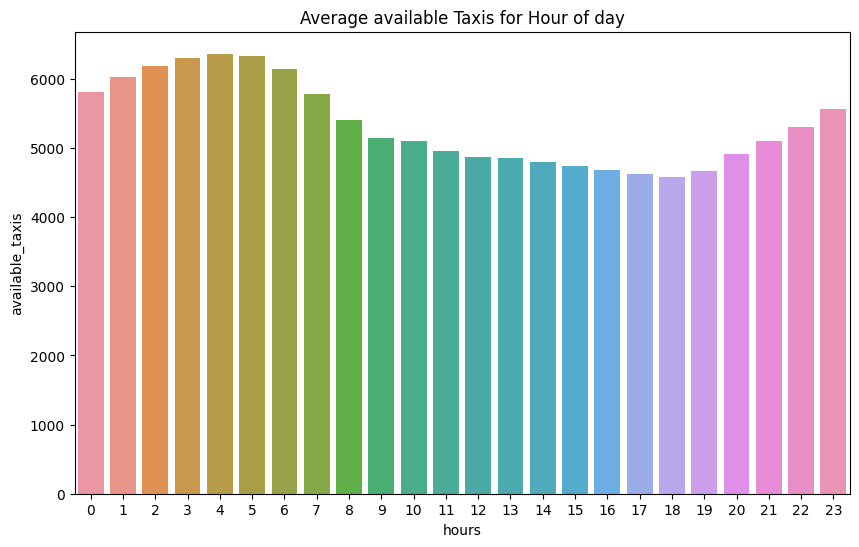

In [23]:
df_pd['hours'] = df_pd['datetime'].dt.hour

df_grouped = df_pd.groupby('hours')['available_taxis'].mean().reset_index()

df_grouped = df_grouped.sort_values('hours')


plt.figure(figsize=(10, 6))
sns.barplot(x='hours', y='available_taxis', data=df_grouped)
plt.title('Average available Taxis for Hour of day')
plt.show()

### Average Utilization plotted over year
We can see there are no extreme seasonal changes in the utilization

<Axes: xlabel='datetime', ylabel='util'>

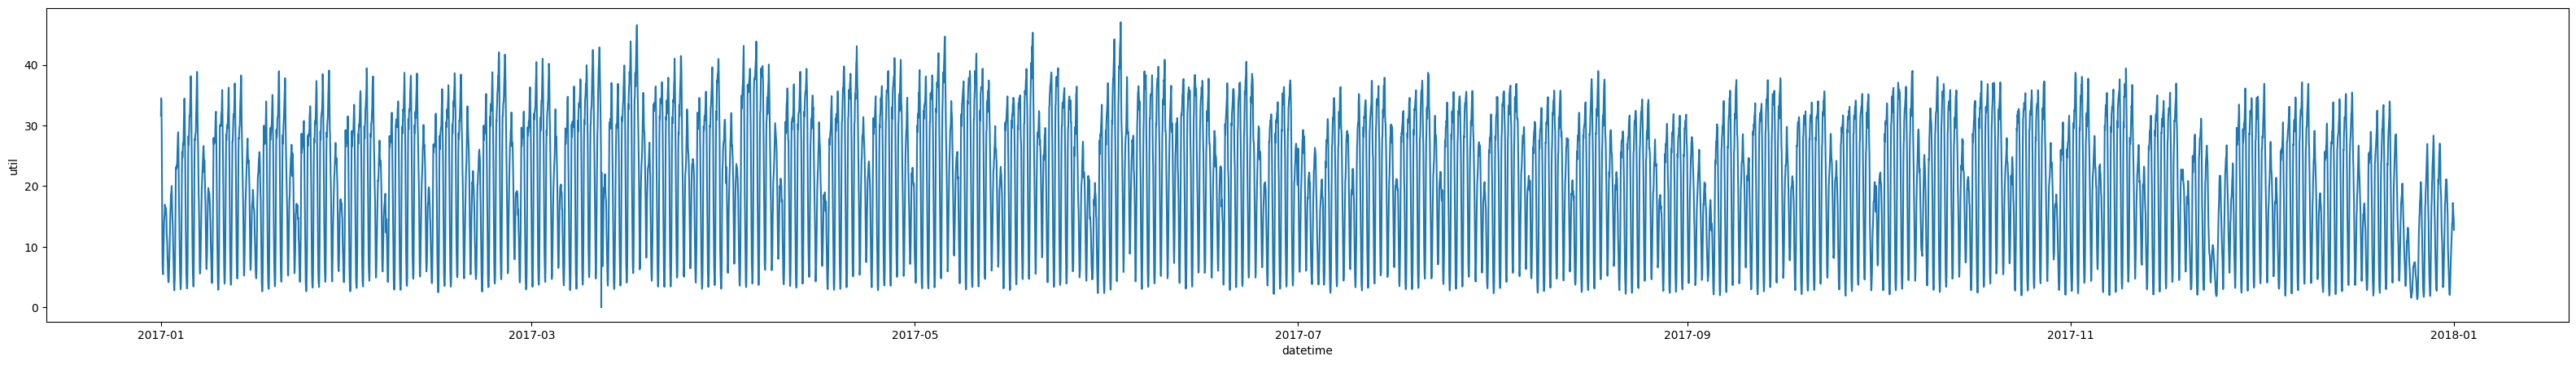

In [24]:

fig, ax = plt.subplots(figsize=(40, 5)) 

sns.lineplot(x="datetime", y="util",
             data=df_pd, ax=ax)

## Revenue

We have the following features that have an influence on the economic information of the dataset
'fare',
 'tips',
 'tolls',
 'extras',
 'trip_total',
 'payment_type',

In [4]:
def format_costs(costs):
    return f"{costs:,.2f}$".replace(".", "#").replace(",", ".").replace("#", ",")


In [5]:
# Global Revenue over year
df = df_cleaned.copy()

global_turnover = df['trip_total'].sum()
global_costs = global_turnover - df['tips'].sum()

print("Gesamte Kosten minus Tips:", format_costs(global_costs))

Gesamte Kosten minus Tips: 296.331.708,49$


### Revenue of Weeks over year
The revenue fluctates stronger than the demand, which we will test in a correlation anlysis (see demand notebook)

<Axes: xlabel='week', ylabel='trip_total_mean'>

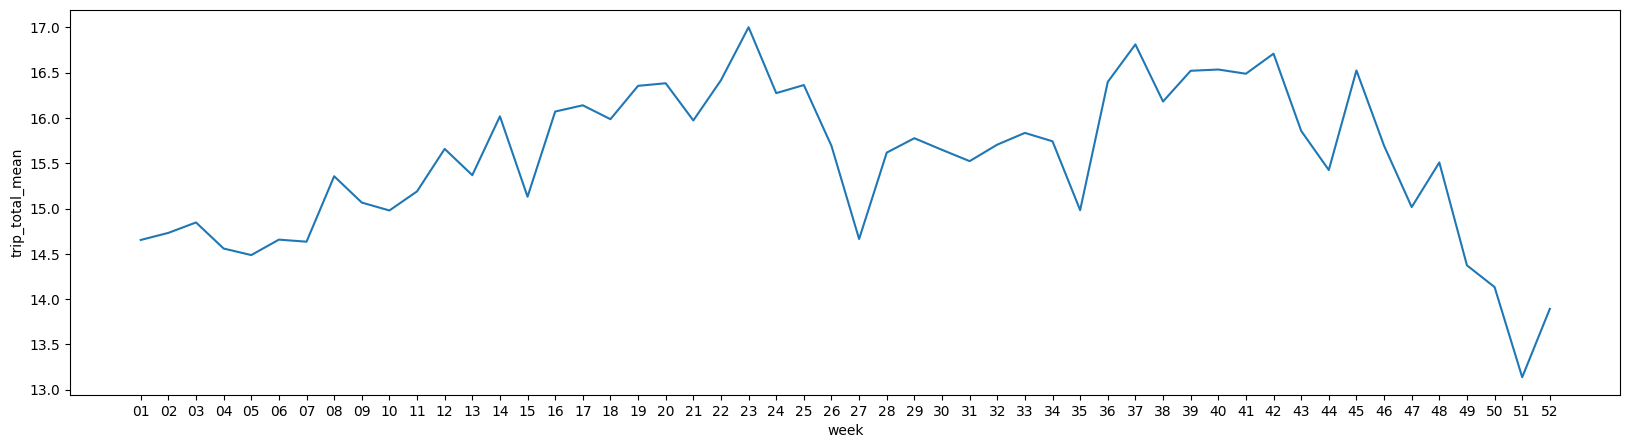

In [27]:
df['week'] = df['trip_start_timestamp'].dt.strftime("%V")
df_grouped = df.groupby('week', agg=vaex.agg.mean('trip_total'))

result = df_grouped.to_pandas_df()
result = result.sort_values('week')

fig, ax = plt.subplots(figsize=(20, 5)) 

sns.lineplot(x="week", y="trip_total_mean",
             data=result, ax=ax)

### Mean of total revenue with tips

In [41]:
df_cleaned['trip_total'].mean()

array(15.60405099)

### Mean of traveled miles

In [42]:
df_cleaned['trip_miles'].mean()

array(3.43721892)

## Cost per miles by hour of day
Except for the early mkoring hours during rush hour there is no strong change in the cost per miles

Average Miles:  3.7055320129275096
Average Cost:  15.829920338115244
Average Cost per Mile:  4.271969661276512


/Users/tobiasramm/anaconda3/envs/AAA_The_Dudes/lib/python3.10/site-packages/vaex/arrow/numpy_dispatch.py:72: RuntimeWarning: divide by zero encountered in divide
  result_data = op['op'](a_data, b_data)


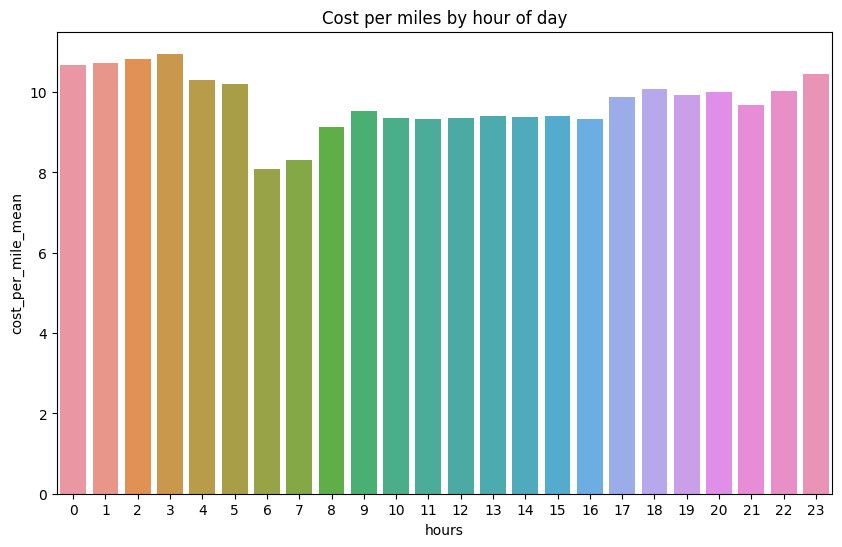

In [6]:
from matplotlib.ticker import FuncFormatter

df = df_cleaned.copy()
df['hours'] = df['trip_start_timestamp'].dt.hour

df = df.dropna(column_names=['trip_miles'])
df = df.dropna(column_names=['trip_total'])
df = df[df['trip_total'] != 0]
df = df[df['trip_miles'] != 0]


print('Average Miles: ', df['trip_miles'].mean())
print('Average Cost: ', df['trip_total'].mean())

print('Average Cost per Mile: ', df['trip_total'].mean() / df['trip_miles'].mean())

df['cost_per_mile'] = df['trip_total'] /  df['trip_miles']


df_grouped = df.groupby('hours', agg=vaex.agg.mean('cost_per_mile'))

df_grouped = df_grouped.to_pandas_df()
df_grouped = df_grouped.sort_values('hours')


plt.figure(figsize=(10, 6))
sns_plot = sns.barplot(x='hours', y='cost_per_mile_mean', data=df_grouped)
plt.title('Cost per miles by hour of day')
plt.show()

## Companies

In [30]:
print('Number of companies: ', df.company.nunique())

Number of companies:  81


In [7]:
def currency_formatter(x, pos):
    return '${:,.2f}'.format(x)

Only a few companys seem to have a strong influence of the revenue which characterizes through the number of taxis per company

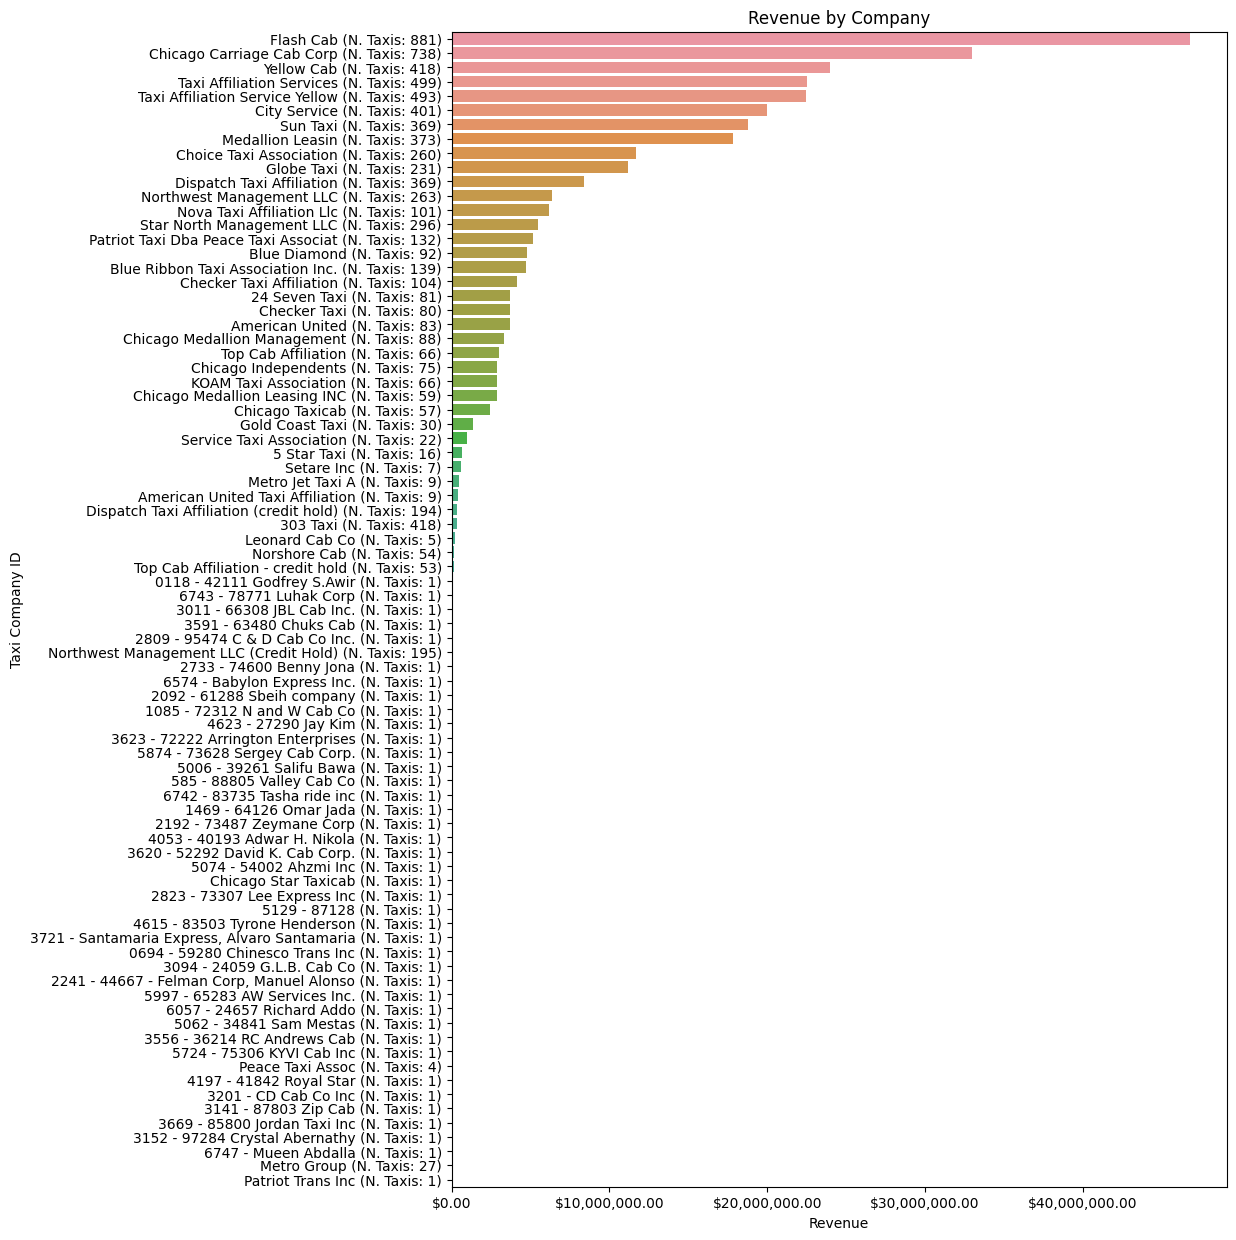

In [8]:
df_grouped = df.groupby('company', agg={
    'trip_total_sum': vaex.agg.sum('trip_total'),
    'num_taxis': vaex.agg.nunique('taxi_id')
})

df_grouped = df_grouped.to_pandas_df()
df_grouped = df_grouped.sort_values('trip_total_sum', ascending=False)

df_grouped['cumulative_revenue'] = df_grouped['trip_total_sum'].cumsum() / global_turnover
df_grouped['company'] = df_grouped.apply(lambda x: x['company'] + " (N. Taxis: " + str(x['num_taxis']) + ")", axis=1)

plt.figure(figsize=[10,15])
sns_plot = sns.barplot(x='trip_total_sum', y='company', data=df_grouped, orient='h')
sns_plot.xaxis.set_major_formatter(FuncFormatter(currency_formatter))
plt.xlabel('Revenue')
plt.ylabel('Taxi Company ID')
plt.title('Revenue by Company')
plt.show()

Plotting the same data on a pie char, it seems that 75% of the revenue are made by only 11 comnpanies 

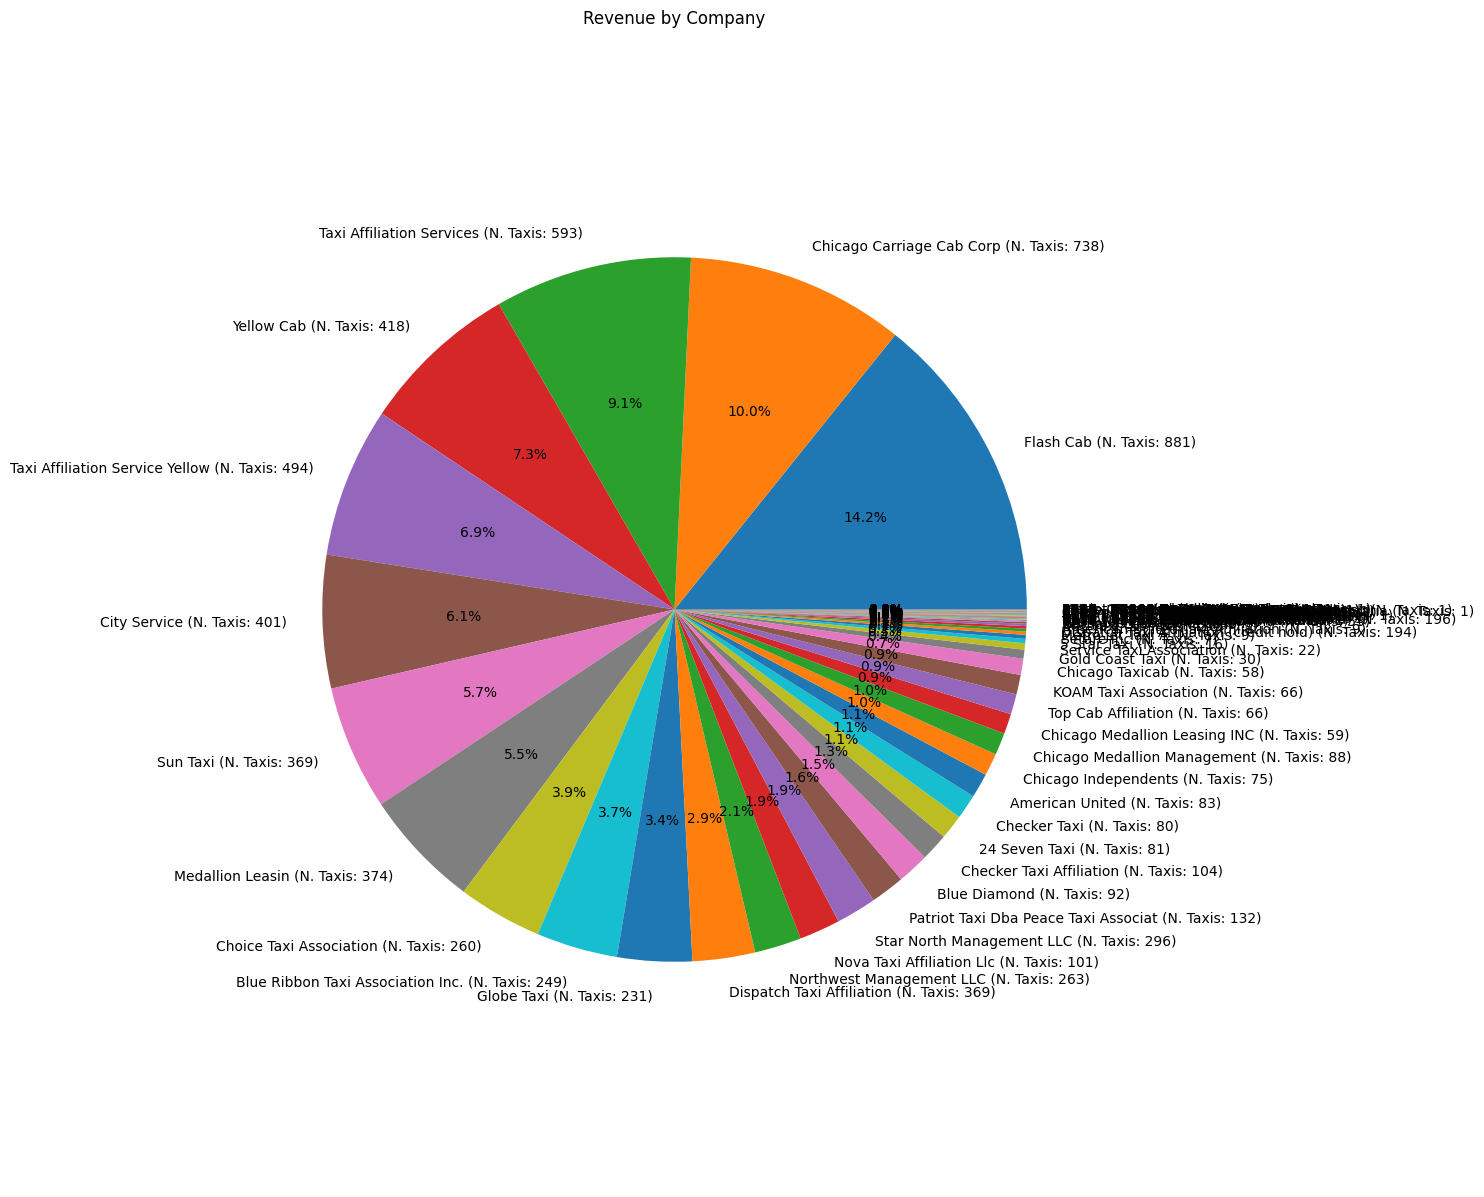

In [33]:
plt.figure(figsize=[10,15])
plt.pie(df_grouped['trip_total_sum'], labels=df_grouped['company'], autopct='%1.1f%%')
plt.axis('equal')  # Gleiches Seitenverhältnis sorgt dafür, dass der Kuchen kreisförmig ist.
plt.title('Revenue by Company')
plt.show()